# **importing relevant libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from sklearn.metrics import f1_score,accuracy_score

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from pathlib import Path
import glob
import skimage
from PIL import Image
import cv2

In [0]:
import torch
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

# Load Data

as i am using Google colab i will have to mount my drive first

In [83]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
## load image data

In [0]:
#set paths
data_path='drive/My Drive/Game of Deep learning/'
img_path=os.path.join(data_path +'/images/')

In [85]:
os.listdir(data_path)

['.ipynb_checkpoints',
 'images',
 '.bashrc',
 'debug.log',
 'sample_submission_ns2btKE.csv',
 'Game of Deep Learning_ Computer Vision Hackathon.pdf',
 'train.csv',
 'test_ApKoW4T.csv',
 'train.zip',
 'game1.ipynb']

In [0]:
files=glob.glob(img_path)
data=[]
for file in files:
  image=cv2.imread(file)
  data.append(image)

In [0]:
# read the csv files
labels=pd.read_csv(data_path +'train.csv')
test_df=pd.read_csv(data_path +'test_ApKoW4T.csv')
submission=pd.read_csv(data_path +'sample_submission_ns2btKE.csv')

# **Data Exploration**

In [0]:
image_files=list(os.listdir(img_path))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 8932


In [0]:
labels.shape,test_df.shape

((6252, 2), (2680, 1))

In [0]:
labels.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [0]:
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [0]:
labels.groupby('category').count()

,image
category,
1,2120
2,1167
3,916
4,832
5,1217


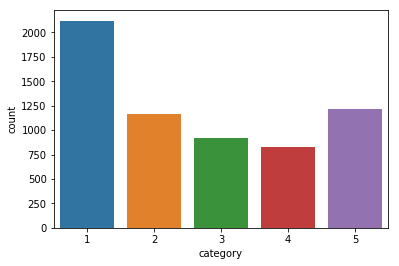

In [0]:
sns.countplot(x='category',data=labels)

In [0]:
#check for missing data
def missing_data (df):
  total=df.isnull().sum().sort_values(ascending=False)
  percentage=(df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
  return pd.concat([total,percentage],axis=1,keys=['Total','percentage'])
missing_data(labels)

,Total,percentage
category,0,0.0
image,0,0.0


In [0]:
#defining classes of images in our dataset
classes={1: 'Cargo',  2: 'Military',  3: 'Carrier',  4: 'Cruise',  5: 'Tankers'}

In [0]:
labels['image_category']=labels['category'].apply(lambda cl:classes[cl])

In [0]:
def draw_category(var,cols=5):
    categories = (labels.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(3*cols,3*len(categories)))
    # draw a number of images for each category
    for i, cat in enumerate(categories):
        sample = labels[labels[var]==cat].sample(cols)
        for j in range(0,cols):
            file=img_path + sample.iloc[j]['image']
            im = PIL.Image.open(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9) 
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

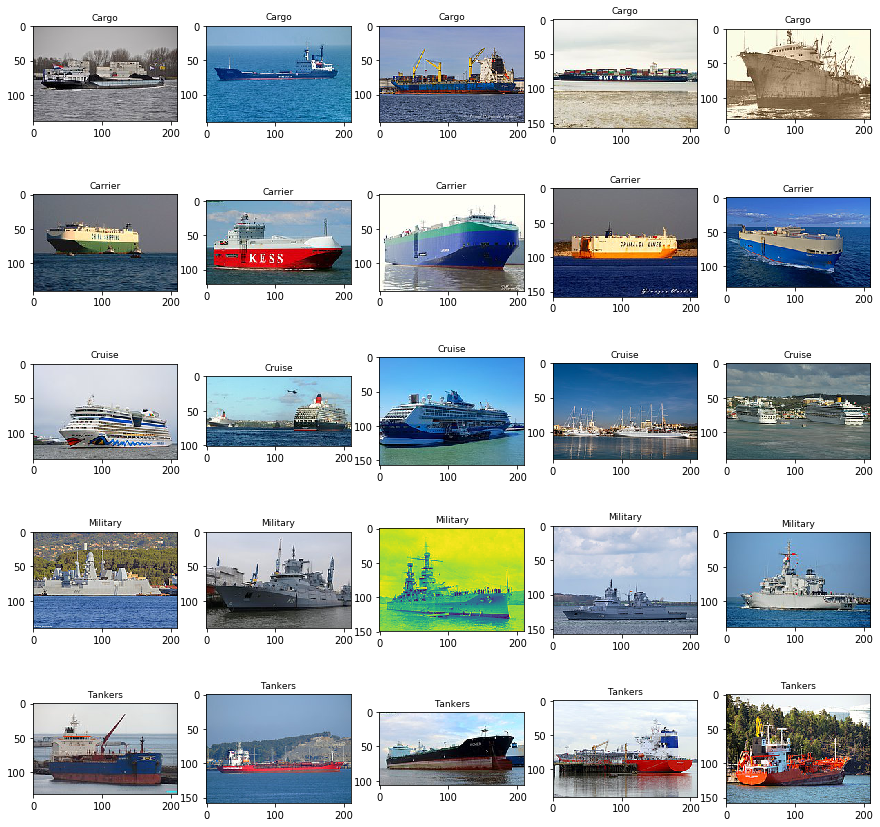

In [0]:
draw_category('image_category')

In [0]:
labels.head()

,image,category,image_category
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


# **modelling**

## **[FROM vision.transform](https://docs.fast.ai/vision.html#Data-augmentation) we can perform various transformations (data augmentation) to the images then later create a data bunch also create a databunch**

In [0]:
doc(get_transforms)

In [0]:
doc(ImageList.from_df)

In [0]:
##transformations to be done to images
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path=data_path, folder='images')

In [0]:
np.random.seed(42)
## create source of train image databunch
src = (ImageList.from_df(labels, path=data_path, folder='images').split_by_rand_pct(0.2).label_from_df().add_test(test_img))

In [0]:
#creating a databunch
data = (src.transform(tfms, size=224,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=64, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [0]:
#classes
print(data.classes)

[1, 2, 3, 4, 5]


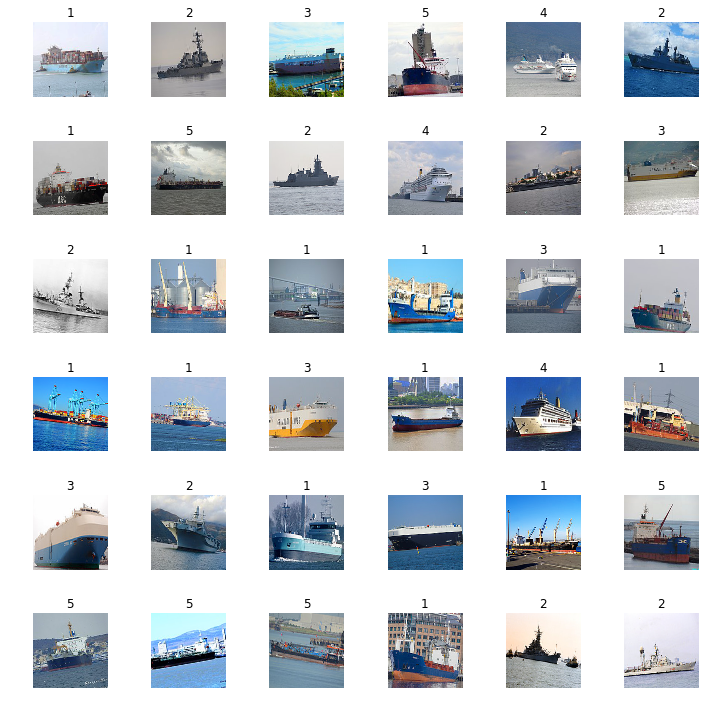

In [0]:
# lets first take a preview of our databunch
data.show_batch(rows=6, figsize=(10,10))

# **create a learner**

# lets take a look at pretrained_models that are available

In [0]:
dir(models)

['BasicBlock',
 'Darknet',
 'DynamicUnet',
 'ResLayer',
 'ResNet',
 'SqueezeNet',
 'UnetBlock',
 'WideResNet',
 'XResNet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet34',
 'xresnet50']

**We will use resnet101 – a 101 layer Convolutional Neural Network. resnet101 has about 44.5 million parameters tuned during the training process. That’s huge!**

In [0]:
doc(cnn_learner)

In [0]:
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[error_rate,accuracy],callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:03<00:00, 50083150.29it/s]


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [0]:
#lets us lr finder to find the optimum learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.179495,0.255372,0.098400,0.901600,01:07
1,0.172398,0.259828,0.096800,0.903200,01:07
2,0.204153,0.301130,0.105600,0.894400,01:07
3,0.184072,0.242928,0.086400,0.913600,01:07
4,0.163275,0.254005,0.084000,0.916000,01:07
5,0.133502,0.262364,0.084000,0.916000,01:07
6,0.101781,0.232641,0.075200,0.924800,01:07
7,0.099509,0.229480,0.068800,0.931200,01:07
8,0.073033,0.249618,0.075200,0.924800,01:07
9,0.066878,0.197160,0.066400,0.933600,01:07


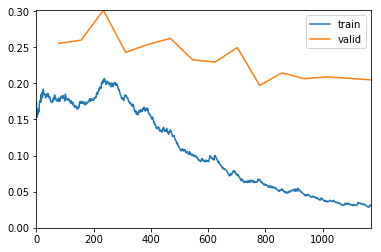

In [48]:
#let us implement our training with a learning rate in the interval of 1e-3 to 1e-01 and also due to the large number of epochs(15) we will implement weight decay param
learn.fit_one_cycle(15,max_lr=slice(1e-03),wd=0.2)

In [0]:
learn.save('step-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-08


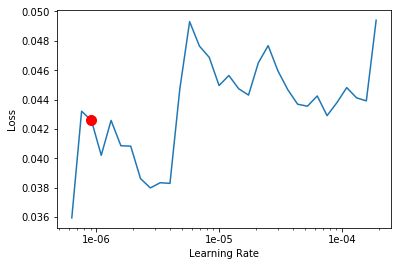

In [50]:
#lets find a better learning rate that can improve our model performance
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.028256,0.205095,0.064800,0.935200,01:30
1,0.026685,0.202397,0.069600,0.930400,01:29
2,0.029970,0.215817,0.067200,0.932800,01:30
3,0.024882,0.200719,0.069600,0.930400,01:29
4,0.023568,0.204818,0.063200,0.936800,01:29
5,0.024641,0.197399,0.060800,0.939200,01:29
6,0.021193,0.188545,0.052000,0.948000,01:30
7,0.014040,0.201991,0.053600,0.946400,01:29
8,0.013605,0.207003,0.058400,0.941600,01:29
9,0.014179,0.195525,0.055200,0.944800,01:29


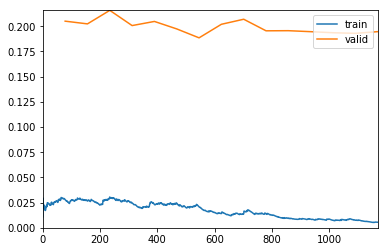

In [51]:
learn.fit_one_cycle(15,max_lr=slice(1e-06,1e-04),wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


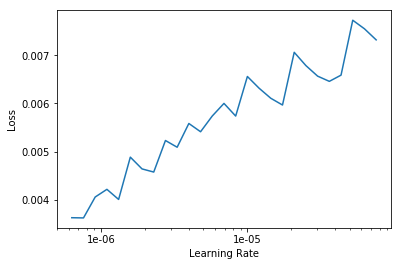

In [52]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestions=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.006506,0.193994,0.055200,0.944800,01:30
1,0.008884,0.209041,0.060800,0.939200,01:29
2,0.011995,0.223188,0.059200,0.940800,01:29
3,0.011252,0.208384,0.057600,0.942400,01:30
4,0.008492,0.207899,0.059200,0.940800,01:31
5,0.005551,0.207301,0.056800,0.943200,01:31
6,0.005282,0.210948,0.059200,0.940800,01:31


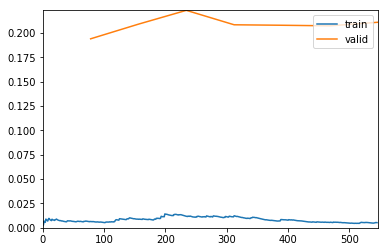

In [53]:
learn.fit_one_cycle(7,slice(1e-06,3e-03/30),wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.005384,0.208420,0.058400,0.941600,01:23
1,0.006002,0.219977,0.060800,0.939200,01:23
2,0.008647,0.217714,0.057600,0.942400,01:23
3,0.006803,0.214372,0.060000,0.940000,01:23
4,0.004725,0.214805,0.060000,0.940000,01:23
5,0.003761,0.214159,0.058400,0.941600,01:23


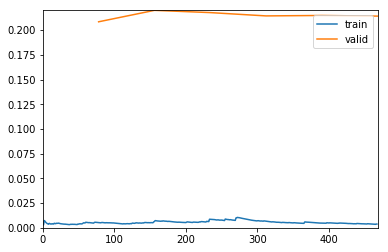

In [54]:
learn.freeze_to(-2)
learn.fit_one_cycle(6,slice(5e-07,3e-03/30),wd=0.05)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.003236,0.215195,0.057600,0.942400,01:08
1,0.003026,0.210984,0.055200,0.944800,01:07
2,0.004338,0.211552,0.056000,0.944000,01:07
3,0.004329,0.213558,0.058400,0.941600,01:07
4,0.003308,0.215514,0.059200,0.940800,01:07


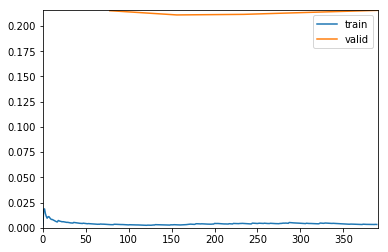

In [55]:
learn.freeze_to(-1)
learn.fit_one_cycle(5,slice(1e-07,3e-03/1000))

## **lets take a look at the mistakes made by our model**

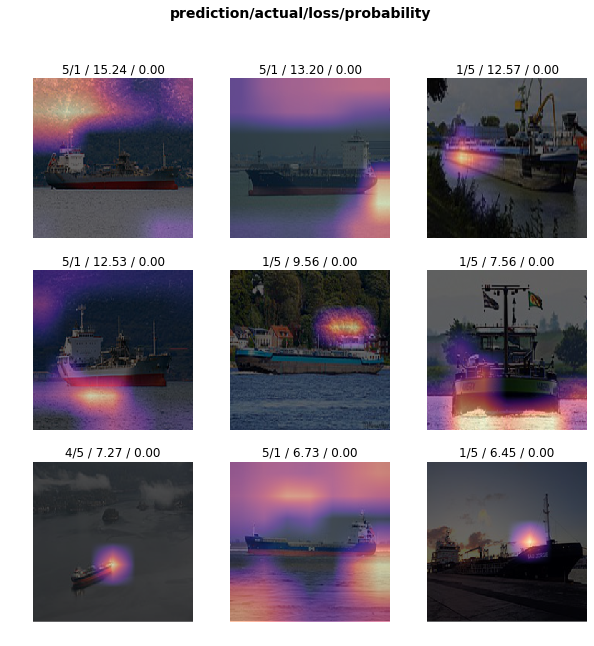

In [56]:
#lets take a look at images predicted with high confidence but were wrongly classified
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(10,10))

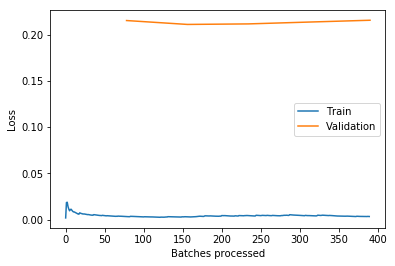

In [57]:
learn.recorder.plot_losses()

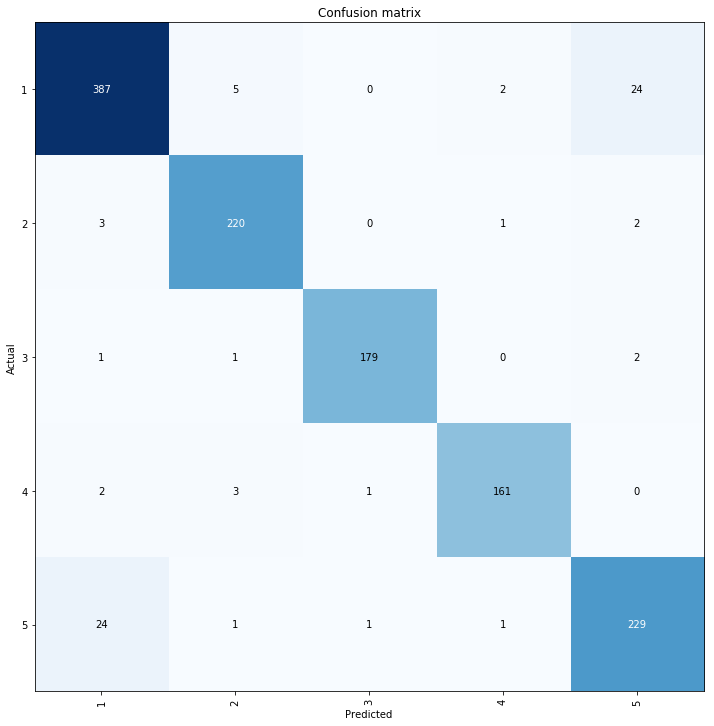

In [59]:
interp.plot_confusion_matrix(figsize=(10,10)) ## on validation set

In [60]:
interp.most_confused(min_val=4) ## on validation set

[(1, 5, 24), (5, 1, 24), (1, 2, 5)]

from above it seems our model had trouble distinguishing between ship category 1(cargo) and 5(tankers) as it classified ships of category 1 as 5 and those of category 5 as category 1, 24 times.

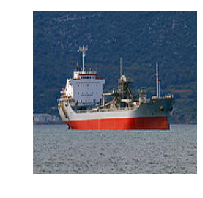

In [62]:
x,y = data.valid_ds[]
x.show()

In [64]:
#learn.TTA 
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

(0.9528, 0.9528)

making predictions

In [65]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [68]:
labelled_preds

array([4, 4, 4, 2, ..., 4, 4, 4, 4])

making a submission file

In [69]:
submission.columns

Index(['image', 'category'], dtype='object')

In [0]:
submission[['category']]=labelled_preds

In [75]:
submission.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [0]:
submission.to_csv('submission.csv',index=False)

In [0]:
#lets write a code that enables us to download the submission file to local machine
from google.colab import files
df.to_csv("submission.csv") 
files.download("submission.csv")